Changelog:  (Last Updated 2024-03-04)

*



# Probabilistic ML: Assignment 3 (start early!)
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [50pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $A$ beats player $B$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_A - z_B)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent, given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b`, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')

    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [10pts]** Implement the missing lines in the code below, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.
    D = mean.size(0)
    epsilon = torch.randn(num_samples, D)
    sample = mean + torch.exp(log_std)* epsilon

    return sample


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    var = torch.exp(2 * log_std)
    sample_pdf = -0.5 * ((x - mean) ** 2 / var + torch.log(2 * torch.pi * var))

    log_pdf_sum = torch.sum(sample_pdf, dim=1)

    return log_pdf_sum

def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples

    samples = diag_gaussian_samples(mean, log_std, num_samples)
    log_p = logprob(samples)


    log_pdf = diag_gaussian_logpdf(samples, mean, log_std)

    # The ELBO is the expectation of log_p minus log_q, estimated by the sample mean
    elbo = torch.mean(log_p - log_pdf)

    return elbo


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  mean, log_std = params
  negative_elbo = -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, mean, log_std, num_samples_per_iter)
  return negative_elbo

**c) [2pts]** Initialize a set of variational parameters and optimize them (written for you already) to approximate the joint distribution where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Any initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  5%|▌         | 40/800 [00:00<00:01, 397.07it/s]

Iteration 0 lower bound 8.96164321899414
Iteration 25 lower bound 10.366816520690918
Iteration 50 lower bound 5.599443435668945
Iteration 75 lower bound 6.35931396484375


 28%|██▊       | 226/800 [00:00<00:00, 590.47it/s]

Iteration 100 lower bound 5.9600067138671875
Iteration 125 lower bound 4.416910171508789
Iteration 150 lower bound 3.6186695098876953
Iteration 175 lower bound 4.279658317565918
Iteration 200 lower bound 3.4903507232666016
Iteration 225 lower bound 3.310194492340088


 46%|████▌     | 368/800 [00:00<00:00, 661.00it/s]

Iteration 250 lower bound 3.5658185482025146
Iteration 275 lower bound 3.133784532546997
Iteration 300 lower bound 3.447427988052368
Iteration 325 lower bound 3.2200706005096436
Iteration 350 lower bound 3.1834070682525635
Iteration 375 lower bound 3.093050956726074


 63%|██████▎   | 506/800 [00:00<00:00, 673.98it/s]

Iteration 400 lower bound 3.0541906356811523
Iteration 425 lower bound 3.1051251888275146
Iteration 450 lower bound 3.3724071979522705
Iteration 475 lower bound 2.908989906311035
Iteration 500 lower bound 2.897528648376465


 72%|███████▏  | 574/800 [00:00<00:00, 538.73it/s]

Iteration 525 lower bound 2.829540967941284
Iteration 550 lower bound 2.816926956176758
Iteration 575 lower bound 3.3118011951446533


 79%|███████▉  | 633/800 [00:01<00:00, 411.80it/s]

Iteration 600 lower bound 2.9110021591186523
Iteration 625 lower bound 2.9003565311431885
Iteration 650 lower bound 3.1902103424072266


 91%|█████████ | 726/800 [00:01<00:00, 378.41it/s]

Iteration 675 lower bound 3.0573229789733887
Iteration 700 lower bound 3.0199825763702393
Iteration 725 lower bound 2.8548901081085205


100%|██████████| 800/800 [00:01<00:00, 469.12it/s]

Iteration 750 lower bound 2.911637306213379
Iteration 775 lower bound 2.8851819038391113


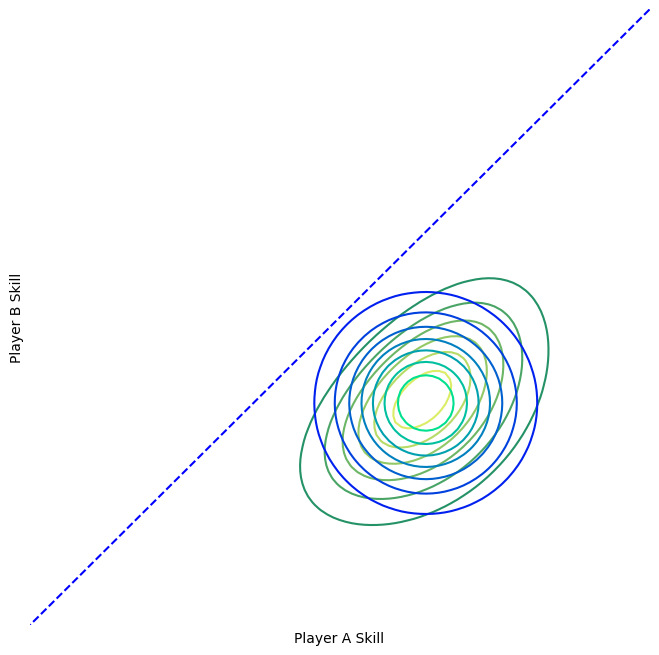

<Figure size 640x480 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_mean = torch.zeros(D, requires_grad=True)
init_log_std = torch.full((D,), -0.01, requires_grad=True)


params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    mean, logstd = params[0].detach(), params[1].detach()
    z = torch.stack([z1, z2], dim=2)
    z_reshaped = z.view(-1, 2)
    logpdf = diag_gaussian_logpdf(z_reshaped, mean, logstd)
    return torch.exp(logpdf.view(z1.shape))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",f2=approx_posterior_2d)

**d) [2pts]** Write a loss function called $\texttt{objective}$  that takes the variational distribution parameters, and returns a negative ELBO estimate using simple Monte Carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint distribution where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)

    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    mean, log_std = params
    negative_elbo = -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, mean, log_std, num_samples_per_iter)
    return negative_elbo

**e) [2pts]** Run the code below to optimize the parameters, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

---

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


100%|██████████| 100/100 [00:00<00:00, 686.64it/s]

Iteration 0 lower bound 18.7126407623291
Iteration 25 lower bound 19.270591735839844
Iteration 50 lower bound 17.366352081298828
Iteration 75 lower bound 16.375152587890625


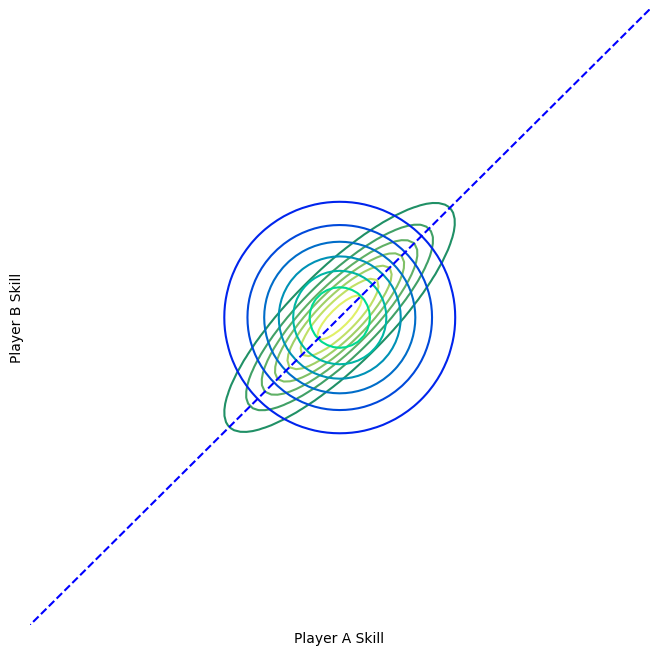

<Figure size 640x480 with 0 Axes>

In [ ]:
# Main loop.
# Reinitialize with the same initialization as you did in 1c) .
init_mean = torch.zeros(D, requires_grad=True)
init_log_std = torch.full((D,), -0.01, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## 1.2 [30pts] Approximate inference conditioned on real data

The dataset contains data on 2546 chess games amongst 1434 players:
 - 'names' is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - 'games' is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column of 'games' contains the indices of the players who won.
The second column of 'games' contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_players.csv")
wget.download("https://vahidbalazadeh.me/assets/datasets/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_id", "loser_id"]].to_numpy()
names = pd.read_csv("chess_players.csv")[["player_name"]].to_numpy().astype('str')


games = torch.LongTensor(games)



**a) [0pts]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ below takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills. (You do not need to code anything here.)

In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs]
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [2pts]** Write a new objective function like the one from the previous question.

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 150

def objective(params):
    mean, log_std = params
    negative_elbo = -batch_elbo(log_joint_probability, mean, log_std, num_samples_per_iter)
    return negative_elbo

**c) [2pts]** Optimize, and report the final loss.

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
for t in trange(0, n_iters):
    update()
    callback(params, t)

  2%|▏         | 10/500 [00:00<00:10, 46.05it/s]

Iteration 0 lower bound 2287.279296875


  7%|▋         | 33/500 [00:00<00:08, 53.07it/s]

Iteration 25 lower bound 2200.9775390625


 11%|█▏        | 57/500 [00:01<00:08, 53.23it/s]

Iteration 50 lower bound 2082.561279296875


 17%|█▋        | 84/500 [00:01<00:07, 58.49it/s]

Iteration 75 lower bound 1992.8616943359375


 22%|██▏       | 109/500 [00:02<00:07, 53.78it/s]

Iteration 100 lower bound 1929.93505859375


 27%|██▋       | 133/500 [00:02<00:06, 53.62it/s]

Iteration 125 lower bound 1882.8145751953125


 31%|███▏      | 157/500 [00:02<00:06, 55.25it/s]

Iteration 150 lower bound 1838.2216796875


 37%|███▋      | 187/500 [00:03<00:05, 55.63it/s]

Iteration 175 lower bound 1804.3985595703125


 42%|████▏     | 211/500 [00:03<00:05, 53.16it/s]

Iteration 200 lower bound 1773.911865234375


 47%|████▋     | 233/500 [00:04<00:05, 46.18it/s]

Iteration 225 lower bound 1745.487548828125


 52%|█████▏    | 258/500 [00:04<00:04, 55.07it/s]

Iteration 250 lower bound 1729.4674072265625


 57%|█████▋    | 283/500 [00:05<00:03, 56.28it/s]

Iteration 275 lower bound 1710.812744140625


 61%|██████    | 306/500 [00:05<00:04, 44.82it/s]

Iteration 300 lower bound 1690.7647705078125


 66%|██████▌   | 330/500 [00:06<00:04, 37.59it/s]

Iteration 325 lower bound 1678.021240234375


 72%|███████▏  | 361/500 [00:07<00:03, 44.92it/s]

Iteration 350 lower bound 1663.93359375


 77%|███████▋  | 386/500 [00:07<00:02, 51.88it/s]

Iteration 375 lower bound 1654.7691650390625


 82%|████████▏ | 411/500 [00:08<00:01, 53.83it/s]

Iteration 400 lower bound 1643.802490234375


 87%|████████▋ | 435/500 [00:08<00:01, 53.85it/s]

Iteration 425 lower bound 1640.6331787109375


 92%|█████████▏| 459/500 [00:09<00:00, 53.56it/s]

Iteration 450 lower bound 1628.8443603515625


 97%|█████████▋| 483/500 [00:09<00:00, 54.34it/s]

Iteration 475 lower bound 1624.331298828125


100%|██████████| 500/500 [00:09<00:00, 50.89it/s]


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

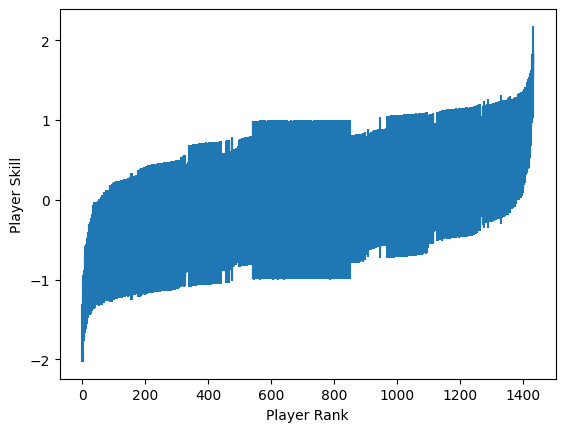

In [ ]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params
mean_skills, logstd_skills = mean_skills.detach(), logstd_skills.detach()
var_skills = torch.exp(2 * logstd_skills)
order = torch.argsort(mean_skills)
sorted_means = mean_skills[order]
sorted_var = var_skills[order]

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), sorted_means, yerr=sorted_var)

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
top10_indices = order[-10:]
top10_names = names[top10_indices]
for name in top10_names[::-1]:
    print(name)



thebestofthebad


**f) [3pt]** Plot samples from the joint posterior over the skills of 'lelik3310' and 'thebestofthebad'. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

['lelik3310']
['thebestofthebad']


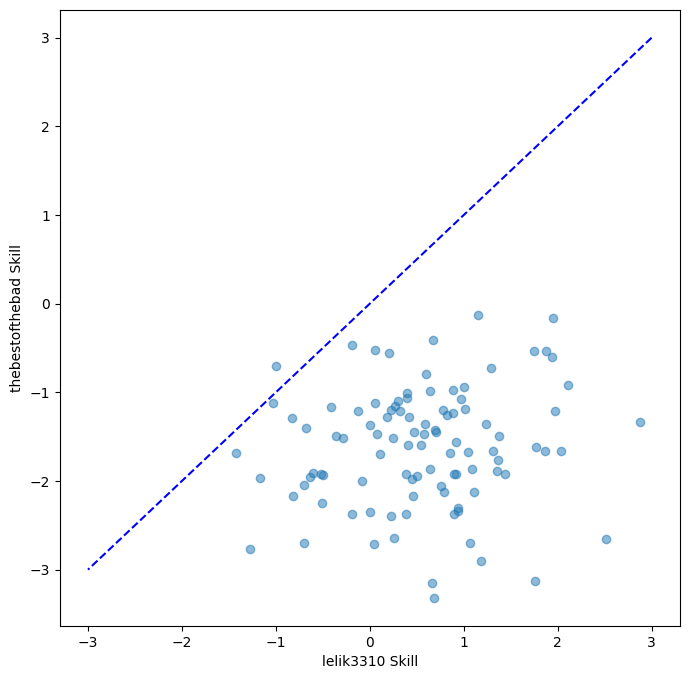

In [ ]:
lelik3310_ix = 568
thebestofthebad_ix = 1051
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill")
plt.ylabel("thebestofthebad Skill")

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
lelik3310_skill_samples = samples[:, lelik3310_ix].detach().numpy()
thebestofthebad_skill_samples = samples[:, thebestofthebad_ix].detach().numpy()

# Plotting the samples
plt.scatter(lelik3310_skill_samples, thebestofthebad_skill_samples, alpha=0.5)


From the scatter plot, the skill of lelik3310 is better than the bestofthebad.  

**g) [6pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^\top)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

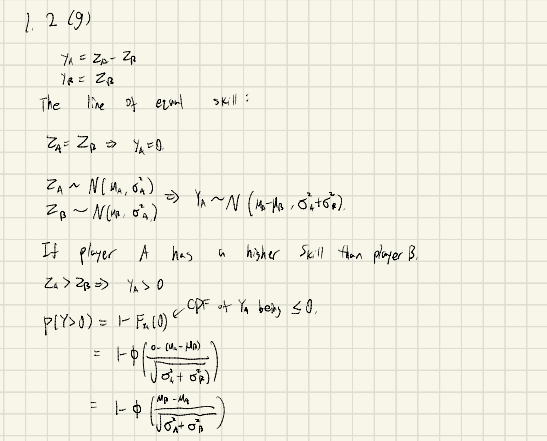

**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    mu_A, sigma_A = mean_skills[A_ix], torch.exp(logstd_skills[A_ix])
    mu_B, sigma_B = mean_skills[B_ix], torch.exp(logstd_skills[B_ix])
    z_score = (mu_B - mu_A) / (sigma_A**2 + sigma_B**2)**0.5
    formula_est = 1 - Normal(0, 1).cdf(z_score)

    samples_A = torch.normal(mu_A, sigma_A, size=(N,))
    samples_B = torch.normal(mu_B, sigma_B, size=(N,))
    mc_est = torch.mean((samples_A > samples_B).float())
    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9878727197647095
Simple MC Estimate: 0.9889000058174133


**i) [3pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
fifth_worst_ix = top10_indices = order[4]
fifth_worst_ix
formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9732480049133301
Simple MC Estimate: 0.9742000102996826


**j) [4pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

If the pirior on all players is Normal(10,1), the answer of both previous two questions would change as the posterior is affected by the prior.


**k) [4pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

I believe simple Monte Carlo producses a better overall approximation to the true posterior as it would theoretically converge to the true posterior given enough sample. The more sample it is given, the better its performance will be. Since we can sample as many games as we want, thus it would perform the best out of all other methods.

# [50pts] Question 2: Expectation-Maximization (EM) algorithm

In [ ]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import matplotlib.pyplot as plt

## 3.1 [8pts] Generating the Data

**a) [5pts]** First, we will generate some data for this problem. Set the number of points $N=400$, their dimension $D=2$, and the number of clusters $K=2$, and generate data from the distribution $p(x|z=k) = N(\mu_k, \Sigma_k)$.
  Sample $200$ data points for $k=1$ and 200 for $k=2$, with

  $$
    \mu_1=
    \begin{bmatrix}
      0.1 \\
      0.1
    \end{bmatrix}
    \ \text{,}\
    \mu_2=
    \begin{bmatrix}
      6.0 \\
      0.1
    \end{bmatrix}
    \ \text{ and }\
    \Sigma_1=\Sigma_2=
    \begin{bmatrix}
      10       & 7 \\
      7 & 10
    \end{bmatrix}
  $$
  Here, $N=400$. If you generate the data, you already know which sample comes from which class. Complete the following statements and run to generate.

  Hint: you can use `np.random.multivariate_normal`.

In [308]:
num_samples = 200
cov = [[10, 7], [7, 10]]
mean_1 = [0.1, 0.1]
mean_2 = [6.0, 0.1]

x_class1 = np.random.multivariate_normal(mean_1, cov, num_samples)
x_class2 = np.random.multivariate_normal(mean_2, cov, num_samples)
xy_class1 = np.hstack((x_class1, np.zeros((x_class1.shape[0], 1))))
xy_class2 = np.hstack((x_class2, np.ones((x_class2.shape[0], 1))))

data_full = np.vstack((xy_class1, xy_class2))
np.random.shuffle(data_full)
data = data_full[:, :-1]
labels = data_full[:, -1]

**b) [3pts]** Make a scatter plot of the data points showing the true cluster assignment of each point using different color codes and shape (x for first class and circles for second class):

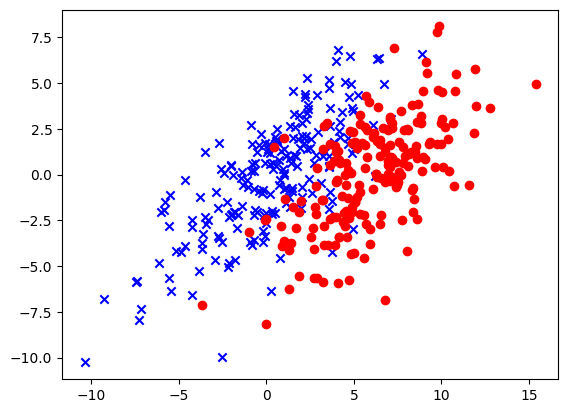

In [309]:
plt.scatter(data[labels == 0][:, 0], data[labels == 0][:, 1], c='blue', marker='x', label='Class 1')
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], c='red', marker='o', label='Class 2')



## 3.2 [14pts] Implement and Run K-Means algorithm

Now, we assume that the true class labels are not known. Implement the k-means algorithm for this problem.
  Write two functions: `km_assignment_step`, and `km_refitting_step` as given in the lecture (Here, `km_` means k-means).
  Identify the correct arguments, and the order to run them. Initialize the algorithm with
  $$
    \hat{\mu}_1=
    \begin{bmatrix}
      0.0 \\
      0.0
    \end{bmatrix}
    \ \text{,}\
    \hat{\mu}_2=
    \begin{bmatrix}
      1.0 \\
      1.0
    \end{bmatrix}
  $$
  and run it until convergence.
  Show the resulting cluster assignments on a scatter plot either using different color codes or shape or both.
  Also plot the cost (distortion in lecture slides) vs. the number of iterations. Report your misclassification error.

**a) [3pts]** Complete the `cost` function.

In [288]:
def cost(data, R, Mu):
    """ Compute the K-Means cost function

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations
        R: an NxK matrix of responsibilities (assignments)

    Returns:
        J: the K-Means cost
    """

    N, D = data.shape
    K = Mu.shape[1]
    J = 0
    for n in range(N):
        for k in range(K):
            J += R[n, k] * np.sum((data[n, :] - Mu[:, k]) ** 2)

    return J


**b) [4pts]** K-Means assignment step.

In [298]:
def km_assignment_step(data, Mu):
    """ Compute K-Means assignment step

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the cluster means locations

    Returns:
        R_new: an NxK matrix of responsibilities
    """

    N, D = data.shape
    K = Mu.shape[1]
    R_new = np.zeros((N, K))

    # TODO assign all r[:, k]
    for i in range(N):
        diff_ary = []
        for k in range(K):
            diff = np.sum((data[i, :] - Mu[:, k]) ** 2)
            diff_ary.append(diff)

        min_index = np.argmin(diff_ary)
        R_new[i, min_index] = 1

    return R_new

**c) [3pts]** K-Means refitting step.

In [295]:
def km_refitting_step(data, R, Mu):
    """ Compute K-Means refitting step.

    Args:
        data: an NxD matrix for the data points
        R: an NxK matrix of responsibilities
        Mu: a DxK matrix for the cluster means locations

    Returns:
        Mu_new: a DxK matrix for the new cluster means locations
    """

    N, D = data.shape
    K = Mu.shape[1]
    Mu_new = np.zeros((D, K))

    for k in range(K):
      k_data = data[R[:, k] == 1]
      Mu_new[:, k] = np.mean(k_data, axis=0)

    return Mu_new

**d) [3pts]** Run this cell to call the K-Means algorithm.

In [311]:
N, D = data.shape
K = 2
max_iter = 100
class_init = np.random.randint(0, K, N)
R = np.zeros((N, K))
R[np.arange(N), class_init] = 1

Mu = np.zeros([D, K])
Mu[:, 1] = 1.
R.T.dot(data), np.sum(R, axis=0)


for it in range(max_iter):
    R = km_assignment_step(data, Mu)
    Mu = km_refitting_step(data, R, Mu)
    print(it, cost(data, R, Mu))


class_1 = data[np.where(R[:, 0] == 1)]
class_2 = data[np.where(R[:, 1] == 1)]


0 5643.947185145745
1 5433.524338499887
2 5368.317729794081
3 5357.657675411366
4 5357.657675411366
5 5357.657675411366
6 5357.657675411366
7 5357.657675411366
8 5357.657675411366
9 5357.657675411366
10 5357.657675411366
11 5357.657675411366
12 5357.657675411366
13 5357.657675411366
14 5357.657675411366
15 5357.657675411366
16 5357.657675411366
17 5357.657675411366
18 5357.657675411366
19 5357.657675411366
20 5357.657675411366
21 5357.657675411366
22 5357.657675411366
23 5357.657675411366
24 5357.657675411366
25 5357.657675411366
26 5357.657675411366
27 5357.657675411366
28 5357.657675411366
29 5357.657675411366
30 5357.657675411366
31 5357.657675411366
32 5357.657675411366
33 5357.657675411366
34 5357.657675411366
35 5357.657675411366
36 5357.657675411366
37 5357.657675411366
38 5357.657675411366
39 5357.657675411366
40 5357.657675411366
41 5357.657675411366
42 5357.657675411366
43 5357.657675411366
44 5357.657675411366
45 5357.657675411366
46 5357.657675411366
47 5357.657675411366
48

**e) [1pt]** Make a scatterplot for the data points showing the K-Means cluster assignments of each point.


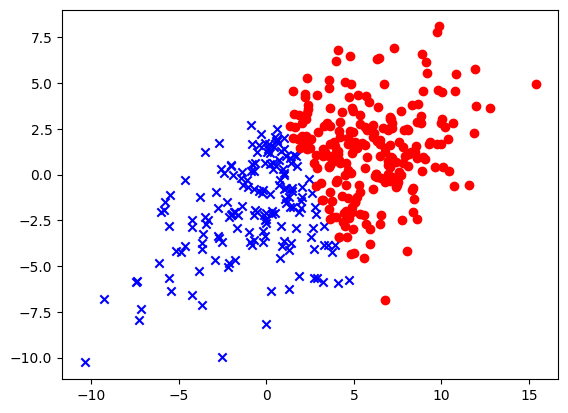

In [312]:
plt.scatter(class_1[:, 0], class_1[:, 1], c='blue', marker='x', label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], c='red', marker='o', label='Class 2')

## 3.3 [19pts] Implement EM algorithm for Gaussian mixtures

Next, implement the EM algorithm for Gaussian mixtures. Write three functions: `log_likelihood`, `gm_e_step`, and `gm_m_step` as given in the lecture.
  - Identify the correct arguments, and the order to run them.
  - Initialize the algorithm with the same initialization as in Q2.1 for the means, and with $\hat\Sigma_1=\hat\Sigma_2=I$, and $\hat\pi_1=\hat\pi_2$.
    
Run the algorithm until convergence and show the resulting cluster assignments on a scatter plot either using different color codes or shape or both. Also plot the log-likelihood vs. the number of iterations. Report your misclassification error.

In [ ]:
def normal_density(x, mu, Sigma):
    return np.exp(-.5 * np.dot(x - mu, np.linalg.solve(Sigma, x - mu))) \
        / np.sqrt(np.linalg.det(2 * np.pi * Sigma))

**a) [5pts]** Log-Likelihood.

In [313]:
def log_likelihood(data, Mu, Sigma, Pi):
    """ Compute log likelihood on the data given the Gaussian Mixture Parameters.

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients

    Returns:
        L: a scalar denoting the log likelihood of the data given the Gaussian Mixture
    """

    N, D = data.shape
    K = Mu.shape[1]
    L, T = 0., 0.
    for n in range(N):
      T = 0.0
      for k in range(K):

          likelihood_nk = normal_density(data[n], Mu[:, k], Sigma[k])
          log_likelihood_n += Pi[k] * likelihood_nk
      L += np.log(T)

    return L

**b) [5pts]** Gaussian Mixture Expectation Step.

In [314]:
def gm_e_step(data, Mu, Sigma, Pi):
    """ Gaussian Mixture Expectation Step.

    Args:
        data: an NxD matrix for the data points
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients

    Returns:
        Gamma: an NxK matrix of responsibilities
    """

    N, D = data.shape
    K = Mu.shape[1]
    Gamma = np.zeros([N, K])

    for n in range(N):
        numerators = np.array([Pi[k] * normal_density(data[n], Mu[:, k], Sigma[k]) for k in range(K)])
        denominator = np.sum(numerators)
        for k in range(K):
            Gamma[n, k] = numerators[k] / denominator
    return Gamma

**c) [5pts]** Gaussian Mixture Maximization Step.

In [315]:
def gm_m_step(data, Gamma):
    """ Gaussian Mixture Maximization Step.

    Args:
        data: an NxD matrix for the data points
        Gamma: an NxK matrix of responsibilities

    Returns:
        Mu: a DxK matrix for the means of the K Gaussian Mixtures
        Sigma: a list of size K with each element being DxD covariance matrix
        Pi: a vector of size K for the mixing coefficients
    """

    N, D = data.shape
    K = Mu.shape[1]
    Nk = np.sum(Gamma, axis=0)
    Sigma = [np.zeros((D, D)) for k in range(K)]
    Pi = np.zeros(K)


    # TODO: fill in Sigma[k] for each k
    for k in range(K):
        Mu[:, k] = np.sum(data * Gamma[:, k, np.newaxis], axis=0) / Nk[k]

        diff = data - Mu[:, k]
        Sigma[k] = (Gamma[:, k, np.newaxis, np.newaxis] * diff[:, np.newaxis, :] * diff[:, :, np.newaxis]).sum(axis=0) / Nk[k]

        Pi[k] = Nk[k] / N

    return Mu, Sigma, Pi

**d) [3pts]** Run this cell to call the Gaussian Mixture EM algorithm.

In [316]:
N, D = data.shape
K = 2
Mu = np.zeros([D, K])
Mu[:, 1] = 1.
Sigma = [np.eye(2), np.eye(2)]
Pi = np.ones(K) / K
Gamma = np.zeros([N, K]) # Gamma is the matrix of responsibilities

max_iter  = 100

for it in range(max_iter):
    Gamma = gm_e_step(data, Mu, Sigma, Pi)
    Mu, Sigma, Pi = gm_m_step(data, Gamma)




class_1 = data[(np.argmax(Gamma, axis=1) == 0)]
class_2 = data[(np.argmax(Gamma, axis=1) == 1)]

**e) [1pt]** Make a scatterplot for the data points showing the Gaussian Mixture cluster assignments of each point

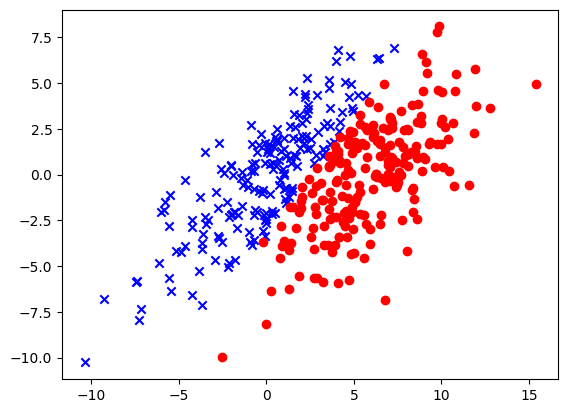

In [317]:
plt.scatter(class_1[:, 0], class_1[:, 1], c='blue', marker='x', label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], c='red', marker='o', label='Class 2')

## 3.4 [9pts] Comment on findings + additional experiments

Comment on the results:

* Compare the performance of k-Means and EM based on the resulting cluster assignments. [2pts]
* Compare the performance of k-Means and EM based on their convergence rate. What is the bottleneck for which method? [2pts]
* Experiment with 5 different data realizations (generate new data), run your algorithms, and summarize your findings. Does the algorithm performance depend on different realizations of data? [3pts]
* Comment on what might happen as you increase the number $K$ of clusters. [1pts]



1. Both k-Means and EM are all cluster methods. The plot produced by k-Mean and EM shows that both of those two method performed well on the clustering assignment.
2. Comparing to EM, k-Means does have a faster converging rate. The bottleneck for k-Means is that it is sensitive towards outliners and it only forms spherical clusters. For EM, the bottleneck would be the computation of e-step has slow convergence rate.
3. After running the two algorithm with 5 different data realization on another document, I found out that the algorithm performance does depend on the different realization of data. For example, if clusters are not circular, then k-Means might perform worse than other data realizations.
4. If I increase the number of K, both k-Means and EM will start to overfit as it split the true cluster into other small clusters.

# [0pts] Question 3: Please fill out the course evaluations.

Did/will you complete the course evaluations? Hint: We would appreciate your feedback.

Yes